In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
import scipy
from sklearn import preprocessing
from scipy import signal
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du
import librosa
import pywt
import random

corpus = tu.Corpus('TIMIT')
train = corpus.train
test = corpus.test
corpus.train, corpus.test


(<timit_utils.core.SubCorpus at 0x1c15f909f48>,
 <timit_utils.core.SubCorpus at 0x1c15f911308>)

### Split sentences into training and testing data

In [4]:
data_set = []
label_id = []
label_gen = []
label_dem = []
for p in range(len(train.people)):
    count = 0
    for s in range(len(train.person_by_index(p).sentences)):
        sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
        data_set.append(sentence)
        label_id.append(train.person_by_index(p).name)
        label_gen.append(train.person_by_index(p).gender)
        label_dem.append(train.person_by_index(p).region_name)
for p in range(len(test.people)):
    count = 0
    for s in range(len(test.person_by_index(p).sentences)):
        sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
        data_set.append(sentence)
        label_id.append(test.person_by_index(p).name)
        label_gen.append(test.person_by_index(p).gender)
        label_dem.append(test.person_by_index(p).region_name)
num_speakers = len(set(label_id))
print('Number of speakers in data: ', num_speakers)

Number of speakers in data:  630


In [5]:
le1 = preprocessing.LabelEncoder()
le1.fit(label_id)
label_id = le1.transform(label_id)
le2 = preprocessing.LabelEncoder()
le2.fit(label_gen)
label_gen = le2.transform(label_gen)
le3 = preprocessing.LabelEncoder()
le3.fit(label_dem)
label_dem = le3.transform(label_dem)

N = 20 # number of speakers being considered
sub_data_set = []
sub_label_id = []
sub_label_gen = []
sub_label_dem = []
speak_ind = []
for ind1 in range(N):
    ind2 = np.random.randint(630, size=1)
    while ind2[0] in speak_ind is False:
        ind2 = np.random.randint(630, size=1)
    speak_ind.append(ind2[0])
act_ind = []
for ID in speak_ind:
    act_ind= np.where(label_id == ID)
    sub_data_set = sub_data_set+data_set[act_ind[0][0]:act_ind[0][-1]+1]
    sub_label_id = sub_label_id+label_id[act_ind[0]].tolist()
    sub_label_gen = sub_label_gen+label_gen[act_ind[0]].tolist()
    sub_label_dem = sub_label_dem+label_dem[act_ind[0]].tolist()

In [16]:
num_train_per_test = 3 # for every 3 training sentences, there is 1 testing sentence
training_set = []
training_label_id = []
training_label_gen = []
training_label_dem = []
testing_set = []
testing_label_id = []
testing_label_gen = []
testing_label_dem = []
for ID in set(sub_label_id):
    person_ind = [i for i, x in enumerate(sub_label_id) if x == ID]
    for i, sent_per_ID in enumerate(person_ind):
        if i%(num_train_per_test+1) == 0:
            testing_set.append(sub_data_set[sent_per_ID])
            testing_label_id.append(sub_label_id[sent_per_ID])
            testing_label_gen.append(sub_label_gen[sent_per_ID])
            testing_label_dem.append(sub_label_dem[sent_per_ID])
        else:
            training_set.append(sub_data_set[sent_per_ID])
            training_label_id.append(sub_label_id[sent_per_ID])
            training_label_gen.append(sub_label_gen[sent_per_ID])
            training_label_dem.append(sub_label_dem[sent_per_ID])

len_samps = 1 # length of samples in seconds
fs = 16000
ave_seconds_per_ID = sum(sentence_lengths)/(fs*len(sentence_lengths))*10
num_samps_per_ID = round(ave_seconds_per_ID)*10
num_samps_per_ID_test = round(num_samps_per_ID*(1/(num_train_per_test+1)))
num_samps_per_ID_train = num_samps_per_ID-num_samps_per_ID_test
training_data = []
training_l_id = []
training_l_gen = []
training_l_dem = []
testing_data = []
testing_l_id = []
testing_l_gen = []
testing_l_dem = []
for ID_i, ID in enumerate(set(sub_label_id)):
    train_person_ind = [i for i, x in enumerate(training_label_id) if x == ID]
    test_person_ind = [i for i, x in enumerate(testing_label_id) if x == ID]
    for samp in range(num_samps_per_ID_train):
        sent = random.choice(train_person_ind)
        while len(training_set[sent]) < round(fs*len_samps):
            sent = random.choice(train_person_ind)
        start_i = random.randint(0,len(training_set[sent])-round(fs*len_samps))
        training_data.append(training_set[sent][start_i:start_i+round(fs*len_samps)])
        training_l_id.append(ID_i)
        training_l_gen.append(training_label_gen[sent])
        training_l_dem.append(training_label_dem[sent])
    for samp in range(num_samps_per_ID_test):
        sent = random.choice(test_person_ind)
        while len(testing_set[sent]) < round(fs*len_samps):
            sent = random.choice(test_person_ind)
        start_i = random.randint(0,len(testing_set[sent])-round(fs*len_samps))
        testing_data.append(testing_set[sent][start_i:start_i+round(fs*len_samps)])
        testing_l_id.append(ID_i)
        testing_l_gen.append(testing_label_gen[sent])
        testing_l_dem.append(testing_label_dem[sent])

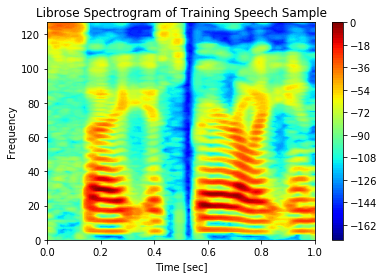

Size of spectrogram is:  (128, 101)


In [17]:
# Use spectrogram from Librosa
plt.title('Librose Spectrogram of Training Speech Sample')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency')
S = librosa.feature.melspectrogram(y=training_data[0], sr=16000, n_fft=1024, hop_length=160)
S = S/np.amax(S)
t = np.arange(0,1.01,0.01)
f = np.arange(0,128,1)
plt.contourf(t,f,20*np.log10(S),100,cmap='jet')
plt.colorbar()
plt.show()
print('Size of spectrogram is: ', np.shape(S))

### Data saved as spectrogram images

In [20]:
# Using Librosa spectrograms.
batch_size = 30
train_loader,test_loader = {},{}
train_list = []
for ind, data in enumerate(training_data):
    spectrogram = librosa.feature.melspectrogram(y=training_data[ind], sr=16000, n_fft=1024, hop_length=160)
    spectrogram = spectrogram/np.amax(spectrogram)
    train_list.append((20*np.log10(abs(spectrogram)), training_l_id[ind], training_l_gen[ind], training_l_dem[ind]))
test_list = []
for ind, data in enumerate(testing_data):
    spectrogram = librosa.feature.melspectrogram(y=testing_data[ind], sr=16000, n_fft=1024, hop_length=160)
    spectrogram = spectrogram/np.amax(spectrogram)
    test_list.append((20*np.log10(abs(spectrogram)), testing_l_id[ind], testing_l_gen[ind], testing_l_dem[ind]))
train_loader['timit'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['timit'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=True, num_workers=0)
print('Done with calculating spectrograms.')

Done with calculating spectrograms.


### Construct the CNN architecture.

In [21]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=30, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=15, kernel_size=3, stride=1)
        self.fc1   = nn.Linear(in_features=15*30*23, out_features=200)
        self.drop1 = nn.Dropout(p=0.5, inplace=False)
        self.fc3_1   = nn.Linear(in_features=200, out_features=out_channels)
        self.fc3_2   = nn.Linear(in_features=200, out_features=out_channels)
        self.fc3_3   = nn.Linear(in_features=200, out_features=out_channels)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x),0)
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.conv2(x),0)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1) # flattens
        x = F.leaky_relu(self.fc1(x),0)
        x = self.drop1(x)
        x1 = F.softmax(self.fc3_1(x),dim=0)
        x2 = F.softmax(self.fc3_2(x),dim=0)
        x3 = F.softmax(self.fc3_3(x),dim=0)
        return x1, x2, x3

In [22]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    model.double()
    for batch_idx, (data, target1, target2, target3) in enumerate(train_loader):
        data, target1, target2, target3=data.to(device), target1.to(device), target2.to(device), target3.to(device)
        data = data.reshape(len(data),1,data[0].size()[0],data[0].size()[1])
        optimizer.zero_grad()
        output1, output2, output3 = model(data)
        loss = (0.9*criterion(output1, target1))+(0.05*criterion(output2, target2))+(0.05*criterion(output3, target3)) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    model.double()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target1, target2, target3 in test_loader:
            data, target1, target2, target3=data.to(device), target1.to(device), target2.to(device), target3.to(device)
            data = data.reshape(len(data),1,data[0].size()[0],data[0].size()[1])
            output1, output2, output3 = model(data)
            test_loss += criterion(output1, target1).item() # sum up batch loss
            pred = output1.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            #print(target)
            #print(pred)
            correct += pred.eq(target1.view_as(pred)).sum().item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, test_loss, 100. * correct / len(test_loader.dataset)))

In [23]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'],nesterov=True)
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

In [24]:
seed = 1
device = 'cpu'
data_name = 'timit'
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'
num_epochs = 20
lr = 0.005
device = torch.device(device)
torch.manual_seed(1)
in_channels = 1
out_channels = N
model = LeNet5(in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0.5, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5,10,15], factor=0.1)
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test(model, device, test_loader[data_name], criterion, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))
    

Train(1)[0%]: Loss: 2.9828
Train(1)[50%]: Loss: 3.0029
Train(1)[99%]: Loss: 2.9970
Test(1): Loss: 3.0166, Accuracy: 16.6667%
Optimizer Learning rate: 0.0050
Train(2)[0%]: Loss: 2.9835
Train(2)[50%]: Loss: 2.9750
Train(2)[99%]: Loss: 2.9645
Test(2): Loss: 2.9577, Accuracy: 33.8057%
Optimizer Learning rate: 0.0050
Train(3)[0%]: Loss: 2.9331
Train(3)[50%]: Loss: 2.9132
Train(3)[99%]: Loss: 2.8925
Test(3): Loss: 2.8308, Accuracy: 55.7355%
Optimizer Learning rate: 0.0050
Train(4)[0%]: Loss: 2.8030
Train(4)[50%]: Loss: 2.8082
Train(4)[99%]: Loss: 2.7876
Test(4): Loss: 2.7625, Accuracy: 60.7962%
Optimizer Learning rate: 0.0050
Train(5)[0%]: Loss: 2.7370
Train(5)[50%]: Loss: 2.7281
Train(5)[99%]: Loss: 2.7129
Test(5): Loss: 2.6680, Accuracy: 61.3360%
Optimizer Learning rate: 0.0005
Train(6)[0%]: Loss: 2.6442
Train(6)[50%]: Loss: 2.6727
Train(6)[99%]: Loss: 2.6696
Test(6): Loss: 2.6512, Accuracy: 61.6734%
Optimizer Learning rate: 0.0005
Train(7)[0%]: Loss: 2.7003
Train(7)[50%]: Loss: 2.6756
Tra